In [2]:
import h5py
import numpy as np
import os
from PIL import Image
from skimage import io
from skimage import exposure
from skimage.viewer import ImageViewer
from subprocess import call
import subprocess
import psycopg2

/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [32]:
f = h5py.File('AnatomyLabelDatabase.hdf5', 'r')

f2 = h5py.File('ZBBDatabase.hdf5', 'r')
from IPython.display import Image

In [164]:
for key in f.keys():
    print key

6.7FRhcrtR-Gal4-uasKaede_6dpf_MeanImageOf12Fish
Anti-5HT_6dpf_MeanImageOf40Fish
Anti-Gad67_6dpf_MeanImageOf17Fish
Anti-GlyR_6dpf_MeanImageOf160Fish
Anti-TH_6dpf_MeanImageOf10Fish
Anti-Zn12(Hnk-1)_6dpf_MeanImageOf9Fish
Anti-Zn1_6dpf_MeanImageOf10Fish
Anti-Znp1(Synaptotagmin2)_6dpf_MeanImageOf118Fish
Anti-Zrf1(GFAP)_6dpf_MeanImageOf5Fish
Anti-Zrf2_6dpf_MeanImageOf5Fish
Anti-tERK_6dpf_MeanImageOf193Fish
Elavl3-GCaMP5G_6dpf_MeanImageOf7Fish
Elavl3-H2BRFP_6dpf_MeanImageOf10Fish
EtVmat2-GFP_6dpf_MeanImageOf55Fish
Gad1b-GFP_6dpf_MeanImageOf10Fish
Glyt2-GFP_6dpf_MeanImageOf13Fish
Hcrt-RFP_6dpf_MeanImageOf15Fish
Isl1-GFP_6dpf_MeanImageOf17Fish
Isl2bGal4-uasDendra_6dpf_MeanImageOf8Fish
Olig2-GFP_6dpf_MeanImageOf12Fish
Otpb.A-Gal4-UAS-GCaMP_6-7dpf_MeanImageOf19Fish
Otpb.A-Nsfb-GFP_6dpf_MeanImageOf10Fish
Oxtl-GFP_6dpf_MeanImageOf68Fish
Pet1-GFP_6dpf_MeanImageOf13Fish
Ptf1aGal4-uasKaede_6dpf_MeanImageOf11Fish
Qrfp-GFP_6dpf_MeanImageOf15Fish
S1181tGal4-uasKaede_6dpf_MeanImageOf14Fish
SpinalBackfills

In [225]:
data = f.get('Elavl3-H2BRFP_6dpf_MeanImageOf10Fish')

In [226]:
# check average grascale intensity
np.mean(data)

3469.5824664000052

In [199]:
data = f2.get('ZBB_y256-Gal4')

In [200]:
# check average grascale intensity
np.mean(data)

92.422028576847339

In [231]:
adj_data0 = data[90]
io.imsave('Test/test_16bit_jpeg0.jpg', adj_data0)

In [246]:
# test immagemagick adjustments
subprocess.check_output(["convert", "Test/test_16bit_jpeg0.jpg", "-format", "jpg", "-level", "0%, 50%", "Test/test_16bit_jpeg1.jpg"], stderr=subprocess.STDOUT)


''

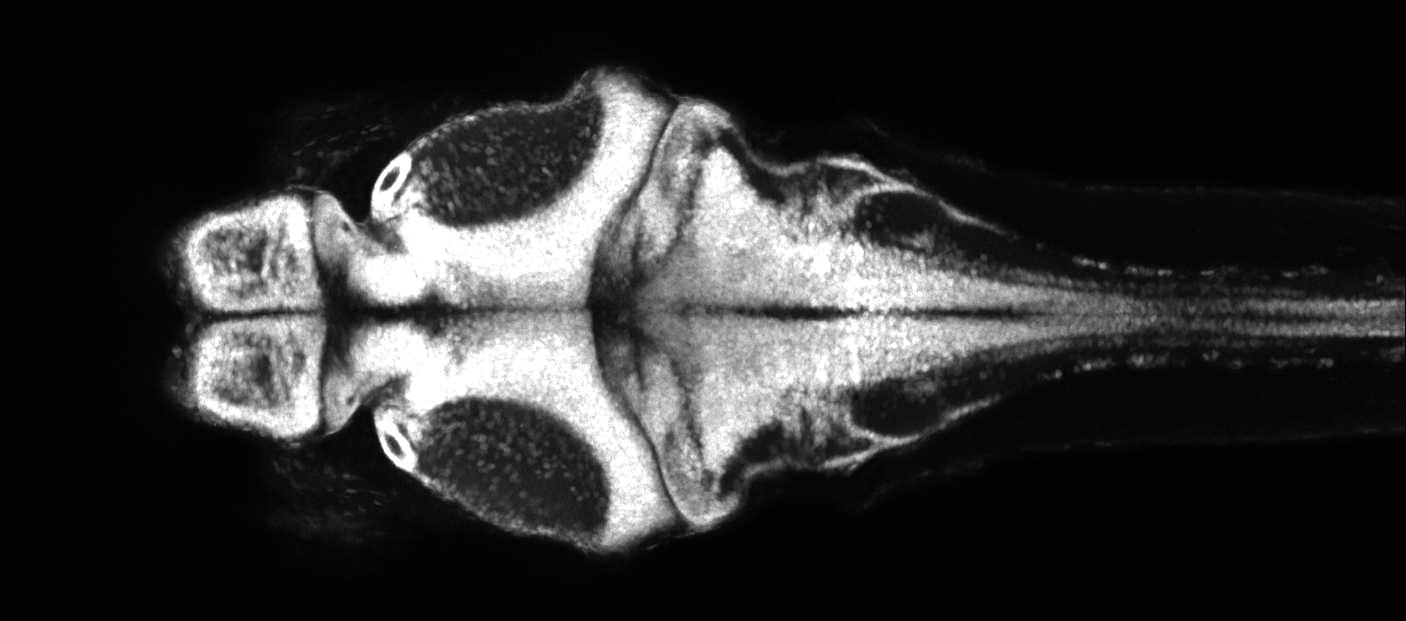

In [247]:
Image("Test/test_16bit_jpeg1.jpg")

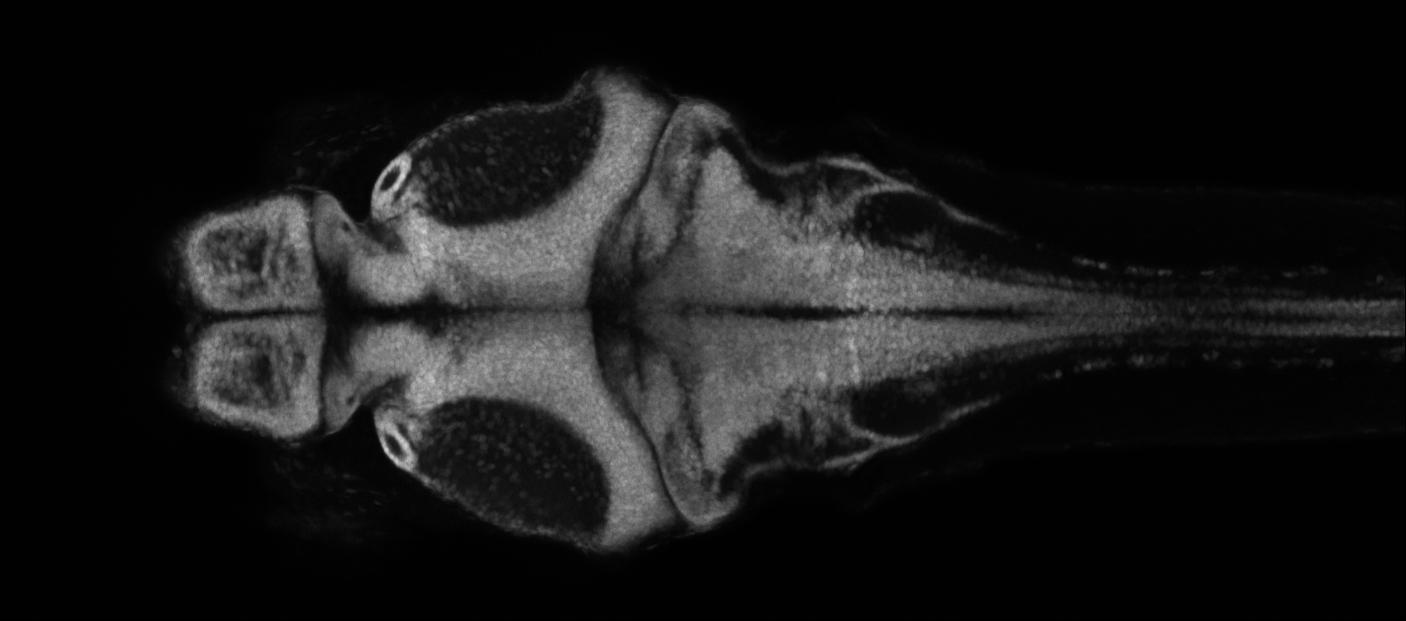

In [239]:
Image("Test/test_16bit_jpeg0.jpg")

In [121]:
print len(f2.keys())
print f2.keys()[62]

109
ZBB_y319-Gal4


In [252]:
# export images from Anatomy hdf5 without creating entries for them in database
for k, key in enumerate(f.keys()[:]):
    stack = f.get(key)
    stack_name = key.split('_')[0]
    folder_path = '../app/assets/images/%s/' % (stack_name)
    print folder_path
    print np.mean(stack)

    try:
        os.makedirs(folder_path)
    except OSError as exception:
        print exception
        
    for i, img in enumerate(stack):
        img_path = '../app/assets/images/%s/%s-%i.jpg' % (stack_name, key, i)
        io.imsave(img_path, stack[i])
        subprocess.check_output(["convert", img_path, "-format", "jpg", "-level", "0%, 50%", img_path], stderr=subprocess.STDOUT)


../app/assets/images/6.7FRhcrtR-Gal4-uasKaede/
2097.70344932
[Errno 17] File exists: '../app/assets/images/6.7FRhcrtR-Gal4-uasKaede/'
../app/assets/images/Anti-5HT/
5949.16077933
[Errno 17] File exists: '../app/assets/images/Anti-5HT/'
../app/assets/images/Anti-Gad67/
3533.79462989
[Errno 17] File exists: '../app/assets/images/Anti-Gad67/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Gad67/Anti-Gad67_6dpf_MeanImageOf17Fish-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Gad67/Anti-Gad67_6dpf_MeanImageOf17Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Anti-GlyR/
927.020210507
[Errno 17] File exists: '../app/assets/images/Anti-GlyR/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-GlyR/Anti-GlyR_6dpf_MeanImageOf160Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-GlyR/Anti-GlyR_6dpf_MeanImageOf160Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-GlyR/Anti-GlyR_6dpf_MeanImageOf160Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-GlyR/Anti-GlyR_6dpf_MeanImageOf160Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images

../app/assets/images/Anti-TH/
3336.02535204
[Errno 17] File exists: '../app/assets/images/Anti-TH/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-TH/Anti-TH_6dpf_MeanImageOf10Fish-135.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-TH/Anti-TH_6dpf_MeanImageOf10Fish-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-TH/Anti-TH_6dpf_MeanImageOf10Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Anti-Zn12(Hnk-1)/
2636.29519186
[Errno 17] File exists: '../app/assets/images/Anti-Zn12(Hnk-1)/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zn12(Hnk-1)/Anti-Zn12(Hnk-1)_6dpf_MeanImageOf9Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Anti-Zn1/
3882.01233311
[Errno 17] File exists: '../app/assets/images/Anti-Zn1/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zn1/Anti-Zn1_6dpf_MeanImageOf10Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zn1/Anti-Zn1_6dpf_MeanImageOf10Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zn1/Anti-Zn1_6dpf_MeanImageOf10Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zn1/Anti-Zn1_6dpf_MeanImageOf10Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zn1/An

../app/assets/images/Anti-Znp1(Synaptotagmin2)/
2146.14675719
[Errno 17] File exists: '../app/assets/images/Anti-Znp1(Synaptotagmin2)/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Znp1(Synaptotagmin2)/Anti-Znp1(Synaptotagmin2)_6dpf_MeanImageOf118Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Znp1(Synaptotagmin2)/Anti-Znp1(Synaptotagmin2)_6dpf_MeanImageOf118Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Znp1(Synaptotagmin2)/Anti-Znp1(Synaptotagmin2)_6dpf_MeanImageOf118Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Znp1(Synaptotagmin2)/Anti-Znp1(Synaptotagmin2)_6dpf_MeanImageOf118Fish-3.jpg is a low contrast image
  warn('%s is a low c

../app/assets/images/Anti-Zrf1(GFAP)/
2185.7053907
[Errno 17] File exists: '../app/assets/images/Anti-Zrf1(GFAP)/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zrf1(GFAP)/Anti-Zrf1(GFAP)_6dpf_MeanImageOf5Fish-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zrf1(GFAP)/Anti-Zrf1(GFAP)_6dpf_MeanImageOf5Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Anti-Zrf2/
4189.31612282
[Errno 17] File exists: '../app/assets/images/Anti-Zrf2/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zrf2/Anti-Zrf2_6dpf_MeanImageOf5Fish-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-Zrf2/Anti-Zrf2_6dpf_MeanImageOf5Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Anti-tERK/
3199.87456586
[Errno 17] File exists: '../app/assets/images/Anti-tERK/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-tERK/Anti-tERK_6dpf_MeanImageOf193Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-tERK/Anti-tERK_6dpf_MeanImageOf193Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-tERK/Anti-tERK_6dpf_MeanImageOf193Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Anti-tERK/Anti-tERK_6dpf_MeanImageOf193Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images

../app/assets/images/Elavl3-GCaMP5G/
2990.69731461
[Errno 17] File exists: '../app/assets/images/Elavl3-GCaMP5G/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Elavl3-GCaMP5G/Elavl3-GCaMP5G_6dpf_MeanImageOf7Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Elavl3-GCaMP5G/Elavl3-GCaMP5G_6dpf_MeanImageOf7Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Elavl3-GCaMP5G/Elavl3-GCaMP5G_6dpf_MeanImageOf7Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Elavl3-GCaMP5G/Elavl3-GCaMP5G_6dpf_MeanImageOf7Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: U

../app/assets/images/Elavl3-H2BRFP/
3469.5824664
[Errno 17] File exists: '../app/assets/images/Elavl3-H2BRFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Elavl3-H2BRFP/Elavl3-H2BRFP_6dpf_MeanImageOf10Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Elavl3-H2BRFP/Elavl3-H2BRFP_6dpf_MeanImageOf10Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Elavl3-H2BRFP/Elavl3-H2BRFP_6dpf_MeanImageOf10Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Elavl3-H2BRFP/Elavl3-H2BRFP_6dpf_MeanImageOf10Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserW

../app/assets/images/EtVmat2-GFP/
2994.89217512
[Errno 17] File exists: '../app/assets/images/EtVmat2-GFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/EtVmat2-GFP/EtVmat2-GFP_6dpf_MeanImageOf55Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/EtVmat2-GFP/EtVmat2-GFP_6dpf_MeanImageOf55Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/EtVmat2-GFP/EtVmat2-GFP_6dpf_MeanImageOf55Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/EtVmat2-GFP/EtVmat2-GFP_6dpf_MeanImageOf55Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Gad1b-GFP/
2685.04314719
[Errno 17] File exists: '../app/assets/images/Gad1b-GFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Gad1b-GFP/Gad1b-GFP_6dpf_MeanImageOf10Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Gad1b-GFP/Gad1b-GFP_6dpf_MeanImageOf10Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Gad1b-GFP/Gad1b-GFP_6dpf_MeanImageOf10Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Gad1b-GFP/Gad1b-GFP_6dpf_MeanImageOf10Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Gad

../app/assets/images/Glyt2-GFP/
2843.22723154
[Errno 17] File exists: '../app/assets/images/Glyt2-GFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Glyt2-GFP/Glyt2-GFP_6dpf_MeanImageOf13Fish-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Glyt2-GFP/Glyt2-GFP_6dpf_MeanImageOf13Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Hcrt-RFP/
2513.37784368
[Errno 17] File exists: '../app/assets/images/Hcrt-RFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Hcrt-RFP/Hcrt-RFP_6dpf_MeanImageOf15Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Hcrt-RFP/Hcrt-RFP_6dpf_MeanImageOf15Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Hcrt-RFP/Hcrt-RFP_6dpf_MeanImageOf15Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Hcrt-RFP/Hcrt-RFP_6dpf_MeanImageOf15Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Hcrt-RFP/Hc

../app/assets/images/Isl1-GFP/
3370.72994483
[Errno 17] File exists: '../app/assets/images/Isl1-GFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Isl1-GFP/Isl1-GFP_6dpf_MeanImageOf17Fish-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Isl1-GFP/Isl1-GFP_6dpf_MeanImageOf17Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Isl2bGal4-uasDendra/
419.586011135
[Errno 17] File exists: '../app/assets/images/Isl2bGal4-uasDendra/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Isl2bGal4-uasDendra/Isl2bGal4-uasDendra_6dpf_MeanImageOf8Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Isl2bGal4-uasDendra/Isl2bGal4-uasDendra_6dpf_MeanImageOf8Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Isl2bGal4-uasDendra/Isl2bGal4-uasDendra_6dpf_MeanImageOf8Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Isl2bGal4-uasDendra/Isl2bGal4-uasDendra_6dpf_MeanImageOf8Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.

../app/assets/images/Olig2-GFP/
5471.55987563
[Errno 17] File exists: '../app/assets/images/Olig2-GFP/'
../app/assets/images/Otpb.A-Gal4-UAS-GCaMP/
7033.31883472
[Errno 17] File exists: '../app/assets/images/Otpb.A-Gal4-UAS-GCaMP/'
../app/assets/images/Otpb.A-Nsfb-GFP/
4645.82173008
[Errno 17] File exists: '../app/assets/images/Otpb.A-Nsfb-GFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Otpb.A-Nsfb-GFP/Otpb.A-Nsfb-GFP_6dpf_MeanImageOf10Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Oxtl-GFP/
1843.92664809
[Errno 17] File exists: '../app/assets/images/Oxtl-GFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Oxtl-GFP/Oxtl-GFP_6dpf_MeanImageOf68Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Oxtl-GFP/Oxtl-GFP_6dpf_MeanImageOf68Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Oxtl-GFP/Oxtl-GFP_6dpf_MeanImageOf68Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Oxtl-GFP/Oxtl-GFP_6dpf_MeanImageOf68Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Oxtl-GFP/Ox

../app/assets/images/Pet1-GFP/
6505.36591282
[Errno 17] File exists: '../app/assets/images/Pet1-GFP/'
../app/assets/images/Ptf1aGal4-uasKaede/
1949.11155589
[Errno 17] File exists: '../app/assets/images/Ptf1aGal4-uasKaede/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Ptf1aGal4-uasKaede/Ptf1aGal4-uasKaede_6dpf_MeanImageOf11Fish-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Ptf1aGal4-uasKaede/Ptf1aGal4-uasKaede_6dpf_MeanImageOf11Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/Qrfp-GFP/
1200.9328986
[Errno 17] File exists: '../app/assets/images/Qrfp-GFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Qrfp-GFP/Qrfp-GFP_6dpf_MeanImageOf15Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Qrfp-GFP/Qrfp-GFP_6dpf_MeanImageOf15Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Qrfp-GFP/Qrfp-GFP_6dpf_MeanImageOf15Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Qrfp-GFP/Qrfp-GFP_6dpf_MeanImageOf15Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Qrfp-GFP/Qr

../app/assets/images/S1181tGal4-uasKaede/
3151.35454143
[Errno 17] File exists: '../app/assets/images/S1181tGal4-uasKaede/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/S1181tGal4-uasKaede/S1181tGal4-uasKaede_6dpf_MeanImageOf14Fish-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/S1181tGal4-uasKaede/S1181tGal4-uasKaede_6dpf_MeanImageOf14Fish-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/SpinalBackfills/
1683.52242201
[Errno 17] File exists: '../app/assets/images/SpinalBackfills/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/SpinalBackfills/SpinalBackfills_6dpf_MeanImageOf23Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/SpinalBackfills/SpinalBackfills_6dpf_MeanImageOf23Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/SpinalBackfills/SpinalBackfills_6dpf_MeanImageOf23Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/SpinalBackfills/SpinalBackfills_6dpf_MeanImageOf23Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_

../app/assets/images/Vglut2a-GFP/
2169.33978154
[Errno 17] File exists: '../app/assets/images/Vglut2a-GFP/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Vglut2a-GFP/Vglut2a-GFP_6dpf_MeanImageOf15Fish-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Vglut2a-GFP/Vglut2a-GFP_6dpf_MeanImageOf15Fish-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Vglut2a-GFP/Vglut2a-GFP_6dpf_MeanImageOf15Fish-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/Vglut2a-GFP/Vglut2a-GFP_6dpf_MeanImageOf15Fish-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/a

In [266]:
# export images from ZBB hdf5 without creating entries for them in database
for k, key in enumerate(f2.keys()[:]):
    stack = f2.get(key)
    stack_name = key
    folder_path = '../app/assets/images/%s/' % (stack_name)
    print folder_path
    mean_intensity = np.mean(stack)
    
    if mean_intensity >= 1000:
        white_point = 50
    elif mean_intensity >= 100 and mean_intensity < 1000:
        white_point = 40
    else:
        white_point = 30

    try:
        os.makedirs(folder_path)
    except OSError as exception:
        print exception
    
    print white_point
    for i, img in enumerate(stack):
        img_path = '../app/assets/images/%s/%s-%i.jpg' % (stack_name, key, i)
        io.imsave(img_path, stack[i])
        subprocess.check_output(["convert", img_path, "-format", "jpg", "-level", "0%%, %i%%" % (white_point) , img_path], stderr=subprocess.STDOUT)
        
        

../app/assets/images/ZBB_HuC-Cer/
[Errno 17] File exists: '../app/assets/images/ZBB_HuC-Cer/'
50
../app/assets/images/ZBB_ath5-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_ath5-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_ath5-GFP/ZBB_ath5-GFP-126.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_ath5-GFP/ZBB_ath5-GFP-127.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_ath5-GFP/ZBB_ath5-GFP-128.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_ath5-GFP/ZBB_ath5-GFP-129.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_ath5-GFP/ZBB_ath5-GFP-130.jpg is a low contrast image
  war

../app/assets/images/ZBB_bActin-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_bActin-GFP/'
50


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_bActin-GFP/ZBB_bActin-GFP-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


../app/assets/images/ZBB_chx10-gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_chx10-gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_chx10-gal4/ZBB_chx10-gal4-115.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_chx10-gal4/ZBB_chx10-gal4-116.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_chx10-gal4/ZBB_chx10-gal4-117.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_chx10-gal4/ZBB_chx10-gal4-118.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_chx10-gal4/ZBB_chx10-gal4-119.jpg is a low 

../app/assets/images/ZBB_dat-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_dat-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dat-GFP/ZBB_dat-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dat-GFP/ZBB_dat-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dat-GFP/ZBB_dat-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dat-GFP/ZBB_dat-GFP-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dat-GFP/ZBB_dat-GFP-4.jpg is a low contrast image
  warn('%s is a low contr

../app/assets/images/ZBB_dbh-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_dbh-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dbh-Gal4/ZBB_dbh-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dbh-Gal4/ZBB_dbh-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dbh-Gal4/ZBB_dbh-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dbh-Gal4/ZBB_dbh-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_dbh-Gal4/ZBB_dbh-Gal4-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_eng1b-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_eng1b-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_eng1b-Gal4/ZBB_eng1b-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_eng1b-Gal4/ZBB_eng1b-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_eng1b-Gal4/ZBB_eng1b-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_eng1b-Gal4/ZBB_eng1b-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_eng1b-Gal4/ZBB_eng1b-Gal4-4.jpg is a low contrast i

../app/assets/images/ZBB_evx2-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_evx2-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_evx2-Gal4/ZBB_evx2-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_evx2-Gal4/ZBB_evx2-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_evx2-Gal4/ZBB_evx2-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_evx2-Gal4/ZBB_evx2-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_evx2-Gal4/ZBB_evx2-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_flk-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_flk-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_flk-GFP/ZBB_flk-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_flk-GFP/ZBB_flk-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_flk-GFP/ZBB_flk-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_flk-GFP/ZBB_flk-GFP-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_flk-GFP/ZBB_flk-GFP-4.jpg is a low contrast image
  warn('%s is a low contr

../app/assets/images/ZBB_gad1b-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_gad1b-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gad1b-GFP/ZBB_gad1b-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gad1b-GFP/ZBB_gad1b-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gad1b-GFP/ZBB_gad1b-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gad1b-GFP/ZBB_gad1b-GFP-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gad1b-GFP/ZBB_gad1b-GFP-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_gfap-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_gfap-GFP/'
50


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gfap-GFP/ZBB_gfap-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gfap-GFP/ZBB_gfap-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gfap-GFP/ZBB_gfap-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gfap-GFP/ZBB_gfap-GFP-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gfap-GFP/ZBB_gfap-GFP-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_glyt2-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_glyt2-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_glyt2-GFP/ZBB_glyt2-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_glyt2-GFP/ZBB_glyt2-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_glyt2-GFP/ZBB_glyt2-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_glyt2-GFP/ZBB_glyt2-GFP-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_glyt2-GFP/ZBB_glyt2-GFP-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_gsx1-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_gsx1-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gsx1-GFP/ZBB_gsx1-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gsx1-GFP/ZBB_gsx1-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gsx1-GFP/ZBB_gsx1-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gsx1-GFP/ZBB_gsx1-GFP-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_gsx1-GFP/ZBB_gsx1-GFP-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_isl2b-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_isl2b-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_isl2b-GFP/ZBB_isl2b-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_isl2b-GFP/ZBB_isl2b-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_isl2b-GFP/ZBB_isl2b-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_isl2b-GFP/ZBB_isl2b-GFP-70.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_isl2b-GFP/ZBB_isl2b-GFP-120.jpg is a low contrast image
  

../app/assets/images/ZBB_j1229-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_j1229-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_j1229-GFP/ZBB_j1229-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_j1229-GFP/ZBB_j1229-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_j1229-GFP/ZBB_j1229-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_j1229-GFP/ZBB_j1229-GFP-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_j1229-GFP/ZBB_j1229-GFP-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_pet1-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_pet1-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_pet1-GFP/ZBB_pet1-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_pet1-GFP/ZBB_pet1-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_pet1-GFP/ZBB_pet1-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_pet1-GFP/ZBB_pet1-GFP-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_pet1-GFP/ZBB_pet1-GFP-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_phox2b-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_phox2b-GFP/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_phox2b-GFP/ZBB_phox2b-GFP-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_phox2b-GFP/ZBB_phox2b-GFP-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_phox2b-GFP/ZBB_phox2b-GFP-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_phox2b-GFP/ZBB_phox2b-GFP-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_phox2b-GFP/ZBB_phox2b-GFP-4.jpg is a low contrast i

../app/assets/images/ZBB_shox2-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_shox2-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_shox2-Gal4/ZBB_shox2-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_shox2-Gal4/ZBB_shox2-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_shox2-Gal4/ZBB_shox2-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_shox2-Gal4/ZBB_shox2-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_shox2-Gal4/ZBB_shox2-Gal4-4.jpg is a low contrast i

../app/assets/images/ZBB_tph2-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_tph2-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_tph2-Gal4/ZBB_tph2-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_tph2-Gal4/ZBB_tph2-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_tph2-Gal4/ZBB_tph2-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_tph2-Gal4/ZBB_tph2-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_tph2-Gal4/ZBB_tph2-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_vglut-DsRed/
[Errno 17] File exists: '../app/assets/images/ZBB_vglut-DsRed/'
50


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_vglut-DsRed/ZBB_vglut-DsRed-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_vglut-DsRed/ZBB_vglut-DsRed-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_vglut-DsRed/ZBB_vglut-DsRed-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_vglut-DsRed/ZBB_vglut-DsRed-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_vglut-DsRed/ZBB_vglut-DsRed-4.jpg is a low 

../app/assets/images/ZBB_y234-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y234-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y234-Gal4/ZBB_y234-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y234-Gal4/ZBB_y234-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y234-Gal4/ZBB_y234-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y234-Gal4/ZBB_y234-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y234-Gal4/ZBB_y234-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y236-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y236-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y236-Gal4/ZBB_y236-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y236-Gal4/ZBB_y236-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y236-Gal4/ZBB_y236-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y236-Gal4/ZBB_y236-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y236-Gal4/ZBB_y236-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y237-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y237-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y237-Gal4/ZBB_y237-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y237-Gal4/ZBB_y237-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y237-Gal4/ZBB_y237-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y237-Gal4/ZBB_y237-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y237-Gal4/ZBB_y237-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y240-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y240-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y240-Gal4/ZBB_y240-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y240-Gal4/ZBB_y240-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y240-Gal4/ZBB_y240-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y240-Gal4/ZBB_y240-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y240-Gal4/ZBB_y240-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y241-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y241-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y241-Gal4/ZBB_y241-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y241-Gal4/ZBB_y241-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y241-Gal4/ZBB_y241-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y241-Gal4/ZBB_y241-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y241-Gal4/ZBB_y241-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y244-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y244-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y244-Gal4/ZBB_y244-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y244-Gal4/ZBB_y244-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y244-Gal4/ZBB_y244-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y244-Gal4/ZBB_y244-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y244-Gal4/ZBB_y244-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y245-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y245-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y245-Gal4/ZBB_y245-Gal4-91.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y245-Gal4/ZBB_y245-Gal4-92.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y245-Gal4/ZBB_y245-Gal4-93.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y245-Gal4/ZBB_y245-Gal4-94.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y245-Gal4/ZBB_y245-Gal4-95.jpg is a low contrast image


../app/assets/images/ZBB_y249-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y249-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y249-Gal4/ZBB_y249-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y249-Gal4/ZBB_y249-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y249-Gal4/ZBB_y249-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y249-Gal4/ZBB_y249-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y249-Gal4/ZBB_y249-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y252-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y252-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y252-Gal4/ZBB_y252-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y252-Gal4/ZBB_y252-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y252-Gal4/ZBB_y252-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y252-Gal4/ZBB_y252-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y252-Gal4/ZBB_y252-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y255-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y255-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y255-Gal4/ZBB_y255-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y255-Gal4/ZBB_y255-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y255-Gal4/ZBB_y255-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y255-Gal4/ZBB_y255-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y255-Gal4/ZBB_y255-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y256-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y256-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y256-Gal4/ZBB_y256-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y256-Gal4/ZBB_y256-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y256-Gal4/ZBB_y256-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y256-Gal4/ZBB_y256-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y256-Gal4/ZBB_y256-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y264-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y264-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y264-Gal4/ZBB_y264-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y264-Gal4/ZBB_y264-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y264-Gal4/ZBB_y264-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y264-Gal4/ZBB_y264-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y264-Gal4/ZBB_y264-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y269-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y269-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y269-Gal4/ZBB_y269-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y269-Gal4/ZBB_y269-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y269-Gal4/ZBB_y269-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y269-Gal4/ZBB_y269-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y269-Gal4/ZBB_y269-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y270-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y270-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y270-Gal4/ZBB_y270-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y270-Gal4/ZBB_y270-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y270-Gal4/ZBB_y270-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y270-Gal4/ZBB_y270-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y270-Gal4/ZBB_y270-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y275-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y275-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y275-Gal4/ZBB_y275-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y275-Gal4/ZBB_y275-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y275-Gal4/ZBB_y275-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y275-Gal4/ZBB_y275-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y275-Gal4/ZBB_y275-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y279-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y279-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y279-Gal4/ZBB_y279-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y279-Gal4/ZBB_y279-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y279-Gal4/ZBB_y279-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y279-Gal4/ZBB_y279-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y279-Gal4/ZBB_y279-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y293-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y293-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y293-Gal4/ZBB_y293-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y293-Gal4/ZBB_y293-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y293-Gal4/ZBB_y293-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y293-Gal4/ZBB_y293-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y293-Gal4/ZBB_y293-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y294-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y294-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y294-Gal4/ZBB_y294-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y294-Gal4/ZBB_y294-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y294-Gal4/ZBB_y294-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y294-Gal4/ZBB_y294-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y294-Gal4/ZBB_y294-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y295-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y295-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y295-Gal4/ZBB_y295-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y295-Gal4/ZBB_y295-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y295-Gal4/ZBB_y295-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y295-Gal4/ZBB_y295-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y295-Gal4/ZBB_y295-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y296-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y296-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y296-Gal4/ZBB_y296-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y296-Gal4/ZBB_y296-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y296-Gal4/ZBB_y296-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y296-Gal4/ZBB_y296-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y296-Gal4/ZBB_y296-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y297-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y297-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y297-Gal4/ZBB_y297-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y297-Gal4/ZBB_y297-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y297-Gal4/ZBB_y297-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y297-Gal4/ZBB_y297-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y297-Gal4/ZBB_y297-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y298-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y298-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y298-Gal4/ZBB_y298-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y298-Gal4/ZBB_y298-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y298-Gal4/ZBB_y298-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y298-Gal4/ZBB_y298-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y298-Gal4/ZBB_y298-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y299-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y299-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y299-Gal4/ZBB_y299-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y299-Gal4/ZBB_y299-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y299-Gal4/ZBB_y299-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y299-Gal4/ZBB_y299-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y299-Gal4/ZBB_y299-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y300-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y300-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y300-Gal4/ZBB_y300-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y300-Gal4/ZBB_y300-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y300-Gal4/ZBB_y300-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y300-Gal4/ZBB_y300-Gal4-121.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y300-Gal4/ZBB_y300-Gal4-122.jpg is a low contrast image
 

../app/assets/images/ZBB_y301-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y301-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y301-Gal4/ZBB_y301-Gal4-86.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y301-Gal4/ZBB_y301-Gal4-87.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y301-Gal4/ZBB_y301-Gal4-88.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y301-Gal4/ZBB_y301-Gal4-89.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y301-Gal4/ZBB_y301-Gal4-90.jpg is a low contrast image


../app/assets/images/ZBB_y302-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y302-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y302-Gal4/ZBB_y302-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y302-Gal4/ZBB_y302-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y302-Gal4/ZBB_y302-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y302-Gal4/ZBB_y302-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y302-Gal4/ZBB_y302-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y303-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y303-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y303-Gal4/ZBB_y303-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y303-Gal4/ZBB_y303-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y303-Gal4/ZBB_y303-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y303-Gal4/ZBB_y303-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y303-Gal4/ZBB_y303-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y304-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y304-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y304-Gal4/ZBB_y304-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y304-Gal4/ZBB_y304-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y304-Gal4/ZBB_y304-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y304-Gal4/ZBB_y304-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y304-Gal4/ZBB_y304-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y305-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y305-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y305-Gal4/ZBB_y305-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y305-Gal4/ZBB_y305-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y305-Gal4/ZBB_y305-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y305-Gal4/ZBB_y305-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y305-Gal4/ZBB_y305-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y306-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y306-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y306-Gal4/ZBB_y306-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y306-Gal4/ZBB_y306-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y306-Gal4/ZBB_y306-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y306-Gal4/ZBB_y306-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y306-Gal4/ZBB_y306-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y307-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y307-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y307-Gal4/ZBB_y307-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y307-Gal4/ZBB_y307-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y307-Gal4/ZBB_y307-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y307-Gal4/ZBB_y307-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y307-Gal4/ZBB_y307-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y308-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y308-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y308-Gal4/ZBB_y308-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y308-Gal4/ZBB_y308-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y308-Gal4/ZBB_y308-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y308-Gal4/ZBB_y308-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y308-Gal4/ZBB_y308-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y309-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y309-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y309-Gal4/ZBB_y309-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y309-Gal4/ZBB_y309-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y309-Gal4/ZBB_y309-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y309-Gal4/ZBB_y309-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y309-Gal4/ZBB_y309-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y310-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y310-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y310-Gal4/ZBB_y310-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y310-Gal4/ZBB_y310-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y310-Gal4/ZBB_y310-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y310-Gal4/ZBB_y310-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y310-Gal4/ZBB_y310-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y311-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y311-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y311-Gal4/ZBB_y311-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y311-Gal4/ZBB_y311-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y311-Gal4/ZBB_y311-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y311-Gal4/ZBB_y311-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y311-Gal4/ZBB_y311-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y312-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y312-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y312-Gal4/ZBB_y312-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y312-Gal4/ZBB_y312-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y312-Gal4/ZBB_y312-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y312-Gal4/ZBB_y312-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y312-Gal4/ZBB_y312-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y313-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y313-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y313-Gal4/ZBB_y313-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y313-Gal4/ZBB_y313-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y313-Gal4/ZBB_y313-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y313-Gal4/ZBB_y313-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y313-Gal4/ZBB_y313-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y314-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y314-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y314-Gal4/ZBB_y314-Gal4-30.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y314-Gal4/ZBB_y314-Gal4-31.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y314-Gal4/ZBB_y314-Gal4-32.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y314-Gal4/ZBB_y314-Gal4-33.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y314-Gal4/ZBB_y314-Gal4-34.jpg is a low contrast image


../app/assets/images/ZBB_y315-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y315-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y315-Gal4/ZBB_y315-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y315-Gal4/ZBB_y315-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y315-Gal4/ZBB_y315-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y315-Gal4/ZBB_y315-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y315-Gal4/ZBB_y315-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y316-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y316-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y316-Gal4/ZBB_y316-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y316-Gal4/ZBB_y316-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y316-Gal4/ZBB_y316-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y316-Gal4/ZBB_y316-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y316-Gal4/ZBB_y316-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y317-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y317-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y317-Gal4/ZBB_y317-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y317-Gal4/ZBB_y317-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y317-Gal4/ZBB_y317-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y317-Gal4/ZBB_y317-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y317-Gal4/ZBB_y317-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y318-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y318-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y318-Gal4/ZBB_y318-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y318-Gal4/ZBB_y318-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y318-Gal4/ZBB_y318-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y318-Gal4/ZBB_y318-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y318-Gal4/ZBB_y318-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y319-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y319-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y319-Gal4/ZBB_y319-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y319-Gal4/ZBB_y319-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y319-Gal4/ZBB_y319-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y319-Gal4/ZBB_y319-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y319-Gal4/ZBB_y319-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y320-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y320-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y320-Gal4/ZBB_y320-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y320-Gal4/ZBB_y320-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y320-Gal4/ZBB_y320-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y320-Gal4/ZBB_y320-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y320-Gal4/ZBB_y320-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y321-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y321-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y321-Gal4/ZBB_y321-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y321-Gal4/ZBB_y321-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y321-Gal4/ZBB_y321-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y321-Gal4/ZBB_y321-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y321-Gal4/ZBB_y321-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y322-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y322-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y323-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y323-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y323-Gal4/ZBB_y323-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y323-Gal4/ZBB_y323-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y323-Gal4/ZBB_y323-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y323-Gal4/ZBB_y323-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y323-Gal4/ZBB_y323-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y324-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y324-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y324-Gal4/ZBB_y324-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y324-Gal4/ZBB_y324-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y324-Gal4/ZBB_y324-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y324-Gal4/ZBB_y324-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y324-Gal4/ZBB_y324-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y325-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y325-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y325-Gal4/ZBB_y325-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y325-Gal4/ZBB_y325-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y325-Gal4/ZBB_y325-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y325-Gal4/ZBB_y325-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y325-Gal4/ZBB_y325-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y326-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y326-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y327-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y327-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y327-Gal4/ZBB_y327-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y327-Gal4/ZBB_y327-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y327-Gal4/ZBB_y327-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y327-Gal4/ZBB_y327-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y327-Gal4/ZBB_y327-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y328-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y328-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y328-Gal4/ZBB_y328-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y328-Gal4/ZBB_y328-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y328-Gal4/ZBB_y328-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y328-Gal4/ZBB_y328-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y328-Gal4/ZBB_y328-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y329-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y329-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y329-Gal4/ZBB_y329-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y329-Gal4/ZBB_y329-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y329-Gal4/ZBB_y329-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y329-Gal4/ZBB_y329-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y329-Gal4/ZBB_y329-Gal4-35.jpg is a low contrast image
  wa

../app/assets/images/ZBB_y330-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y330-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y330-Gal4/ZBB_y330-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y330-Gal4/ZBB_y330-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y330-Gal4/ZBB_y330-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y330-Gal4/ZBB_y330-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y330-Gal4/ZBB_y330-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y331-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y331-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y331-Gal4/ZBB_y331-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y331-Gal4/ZBB_y331-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y331-Gal4/ZBB_y331-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y331-Gal4/ZBB_y331-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y331-Gal4/ZBB_y331-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y332-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y332-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y333-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y333-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y334-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y334-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y334-Gal4/ZBB_y334-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y334-Gal4/ZBB_y334-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y334-Gal4/ZBB_y334-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y334-Gal4/ZBB_y334-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y334-Gal4/ZBB_y334-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y336-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y336-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y337-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y337-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y338-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y338-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y339-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y339-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y339-Gal4/ZBB_y339-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y339-Gal4/ZBB_y339-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y339-Gal4/ZBB_y339-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y339-Gal4/ZBB_y339-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y339-Gal4/ZBB_y339-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y341-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y341-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y341-Gal4/ZBB_y341-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y341-Gal4/ZBB_y341-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y341-Gal4/ZBB_y341-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y341-Gal4/ZBB_y341-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y341-Gal4/ZBB_y341-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y342-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y342-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y342-Gal4/ZBB_y342-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y342-Gal4/ZBB_y342-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y342-Gal4/ZBB_y342-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y342-Gal4/ZBB_y342-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y342-Gal4/ZBB_y342-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y345-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y345-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y347-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y347-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y351-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y351-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y352-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y352-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y352-Gal4/ZBB_y352-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:136: UserWarning: Downcasting uint16 to uint8 without scaling because max value 229 fits in uint8
  warn(msg)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y352-Gal4/ZBB_y352-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y352-Gal4/ZBB_y352-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y352-Gal4/ZBB_y352-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast imag

../app/assets/images/ZBB_y353-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y353-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y353-Gal4/ZBB_y353-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y353-Gal4/ZBB_y353-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y353-Gal4/ZBB_y353-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y353-Gal4/ZBB_y353-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y353-Gal4/ZBB_y353-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y354-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y354-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y354-Gal4/ZBB_y354-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y354-Gal4/ZBB_y354-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y354-Gal4/ZBB_y354-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y354-Gal4/ZBB_y354-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y354-Gal4/ZBB_y354-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y355-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y355-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y355-Gal4/ZBB_y355-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y355-Gal4/ZBB_y355-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y355-Gal4/ZBB_y355-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y355-Gal4/ZBB_y355-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y355-Gal4/ZBB_y355-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y356-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y356-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y356-Gal4/ZBB_y356-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y356-Gal4/ZBB_y356-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y356-Gal4/ZBB_y356-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y356-Gal4/ZBB_y356-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y356-Gal4/ZBB_y356-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y357-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y357-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y358-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y358-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y359-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y359-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y364-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y364-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y364-Gal4/ZBB_y364-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y364-Gal4/ZBB_y364-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y364-Gal4/ZBB_y364-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y364-Gal4/ZBB_y364-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y364-Gal4/ZBB_y364-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y365-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y365-Gal4/'
50


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y365-Gal4/ZBB_y365-Gal4-123.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y365-Gal4/ZBB_y365-Gal4-124.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y365-Gal4/ZBB_y365-Gal4-125.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y365-Gal4/ZBB_y365-Gal4-126.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y365-Gal4/ZBB_y365-Gal4-127.jpg is a low contrast i

../app/assets/images/ZBB_y371-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y371-Cre/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y371-Cre/ZBB_y371-Cre-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y371-Cre/ZBB_y371-Cre-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y371-Cre/ZBB_y371-Cre-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y371-Cre/ZBB_y371-Cre-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y371-Cre/ZBB_y371-Cre-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_y372-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y372-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y372-Gal4/ZBB_y372-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y372-Gal4/ZBB_y372-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y372-Gal4/ZBB_y372-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y372-Gal4/ZBB_y372-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y372-Gal4/ZBB_y372-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y373-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y373-Gal4/'
30


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y373-Gal4/ZBB_y373-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y373-Gal4/ZBB_y373-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y373-Gal4/ZBB_y373-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y373-Gal4/ZBB_y373-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y373-Gal4/ZBB_y373-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y375-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y375-Gal4/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y375-Gal4/ZBB_y375-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y375-Gal4/ZBB_y375-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y375-Gal4/ZBB_y375-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y375-Gal4/ZBB_y375-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y375-Gal4/ZBB_y375-Gal4-4.jpg is a low contrast image
  war

../app/assets/images/ZBB_y378-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y378-Cre/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y378-Cre/ZBB_y378-Cre-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y378-Cre/ZBB_y378-Cre-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y378-Cre/ZBB_y378-Cre-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y378-Cre/ZBB_y378-Cre-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y378-Cre/ZBB_y378-Cre-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_y379-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y379-Cre/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y379-Cre/ZBB_y379-Cre-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y379-Cre/ZBB_y379-Cre-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y379-Cre/ZBB_y379-Cre-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y379-Cre/ZBB_y379-Cre-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y379-Cre/ZBB_y379-Cre-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_y380-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y380-Cre/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_y381-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y381-Cre/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y381-Cre/ZBB_y381-Cre-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y381-Cre/ZBB_y381-Cre-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y381-Cre/ZBB_y381-Cre-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y381-Cre/ZBB_y381-Cre-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y381-Cre/ZBB_y381-Cre-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_y382-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y382-Cre/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y382-Cre/ZBB_y382-Cre-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y382-Cre/ZBB_y382-Cre-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y382-Cre/ZBB_y382-Cre-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y382-Cre/ZBB_y382-Cre-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y382-Cre/ZBB_y382-Cre-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_y383-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y383-Cre/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y383-Cre/ZBB_y383-Cre-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y383-Cre/ZBB_y383-Cre-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y383-Cre/ZBB_y383-Cre-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y383-Cre/ZBB_y383-Cre-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y383-Cre/ZBB_y383-Cre-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_y384-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y384-Cre/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y384-Cre/ZBB_y384-Cre-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y384-Cre/ZBB_y384-Cre-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y384-Cre/ZBB_y384-Cre-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y384-Cre/ZBB_y384-Cre-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y384-Cre/ZBB_y384-Cre-4.jpg is a low contrast image
  warn('%s is a

../app/assets/images/ZBB_y385-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y385-Cre/'
40


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y385-Cre/ZBB_y385-Cre-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y385-Cre/ZBB_y385-Cre-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y385-Cre/ZBB_y385-Cre-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y385-Cre/ZBB_y385-Cre-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y385-Cre/ZBB_y385-Cre-4.jpg is a low contrast image
  warn('%s is a

In [264]:
conn = psycopg2.connect(dbname='zbrain2db', user='gqe', host='localhost', password='')
cursor = conn.cursor()

In [22]:
# export images from hdf5s and create entries for them in database

counter = 0;
counter2 = 4002;
for k, key in enumerate(f2.keys()[:]):
    #stack = f.get(key)
    #stack_name = key.split('_')[0]
    stack = f2.get(key)
    stack_name = key
    folder_path = '../app/assets/images/%s/' % (stack_name)
    rel_folder_path = 'images/%s/' % (stack_name)
    print rel_folder_path
    
    try:
        os.makedirs(folder_path)
    except OSError as exception:
        print exception
        
    for i, img in enumerate(stack):
        adapthist_adjusted = exposure.equalize_adapthist(stack[i])
        img_path = '../app/assets/images/%s/%s-%i.jpg' % (stack_name, key, i)
        rel_img_path = 'images/%s/%s-%i.jpg' % (stack_name, key, i)
        io.imsave(img_path, adapthist_adjusted)
        
        insert_command = ("INSERT INTO images (image_id, line_name, image_path) values (%i, '%s', '%s')" 
                % (counter, stack_name, rel_img_path))
        
        update_command = ("UPDATE images SET image_path='%s' WHERE image_id=%i" 
                         % (rel_img_path, counter2))
        try:
            #print update_command
            cursor.execute(update_command)
            counter2 += 1
        except Exception, e:
            print repr(e)


images/ZBB_HuC-Cer/
[Errno 17] File exists: '../app/assets/images/ZBB_HuC-Cer/'
images/ZBB_ath5-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_ath5-GFP/'
images/ZBB_bActin-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_bActin-GFP/'
images/ZBB_chx10-gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_chx10-gal4/'
images/ZBB_dat-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_dat-GFP/'
images/ZBB_dbh-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_dbh-Gal4/'
images/ZBB_eng1b-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_eng1b-Gal4/'
images/ZBB_evx2-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_evx2-Gal4/'
images/ZBB_flk-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_flk-GFP/'
images/ZBB_gad1b-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_gad1b-GFP/'
images/ZBB_gfap-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_gfap-GFP/'
images/ZBB_glyt2-GFP/
[Errno 17] File exists: '../app/assets/images/ZBB_glyt2-GFP/'
imag

/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y321-Gal4/ZBB_y321-Gal4-135.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y321-Gal4/ZBB_y321-Gal4-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y322-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y322-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-18.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-19.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-20.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-21.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y322-Gal4/ZBB_y322-Gal4-41.jpg is a low contrast image


images/ZBB_y323-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y323-Gal4/'
images/ZBB_y324-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y324-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y324-Gal4/ZBB_y324-Gal4-7.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y324-Gal4/ZBB_y324-Gal4-8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y324-Gal4/ZBB_y324-Gal4-9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y324-Gal4/ZBB_y324-Gal4-10.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y325-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y325-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y325-Gal4/ZBB_y325-Gal4-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y325-Gal4/ZBB_y325-Gal4-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y326-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y326-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y326-Gal4/ZBB_y326-Gal4-4.jpg is a low contrast image
  war

images/ZBB_y327-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y327-Gal4/'
images/ZBB_y328-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y328-Gal4/'
images/ZBB_y329-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y329-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y329-Gal4/ZBB_y329-Gal4-136.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y329-Gal4/ZBB_y329-Gal4-137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y330-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y330-Gal4/'
images/ZBB_y331-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y331-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y331-Gal4/ZBB_y331-Gal4-6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y332-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y332-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-43.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-44.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-45.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-46.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y332-Gal4/ZBB_y332-Gal4-47.jpg is a low contrast image


images/ZBB_y333-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y333-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-53.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-54.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-55.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-56.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y333-Gal4/ZBB_y333-Gal4-57.jpg is a low contrast image


images/ZBB_y334-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y334-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y334-Gal4/ZBB_y334-Gal4-24.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y334-Gal4/ZBB_y334-Gal4-26.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y336-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y336-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y336-Gal4/ZBB_y336-Gal4-4.jpg is a low contrast image
  war

images/ZBB_y337-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y337-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y337-Gal4/ZBB_y337-Gal4-4.jpg is a low contrast image
  war

images/ZBB_y338-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y338-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-13.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-14.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-15.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-16.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y338-Gal4/ZBB_y338-Gal4-17.jpg is a low contrast image


images/ZBB_y339-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y339-Gal4/'
images/ZBB_y341-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y341-Gal4/'
images/ZBB_y342-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y342-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y342-Gal4/ZBB_y342-Gal4-30.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y342-Gal4/ZBB_y342-Gal4-31.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y342-Gal4/ZBB_y342-Gal4-33.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y345-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y345-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-28.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-29.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-30.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-31.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y345-Gal4/ZBB_y345-Gal4-32.jpg is a low contrast image


images/ZBB_y347-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y347-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-37.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-38.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-40.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-41.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y347-Gal4/ZBB_y347-Gal4-42.jpg is a low contrast image


images/ZBB_y351-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y351-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y351-Gal4/ZBB_y351-Gal4-6.jpg is a low contrast image
  war

images/ZBB_y352-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y352-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y352-Gal4/ZBB_y352-Gal4-8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y352-Gal4/ZBB_y352-Gal4-9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y352-Gal4/ZBB_y352-Gal4-18.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y352-Gal4/ZBB_y352-Gal4-19.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y352-Gal4/ZBB_y352-Gal4-20.jpg is a low contrast image
  

images/ZBB_y353-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y353-Gal4/'
images/ZBB_y354-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y354-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y354-Gal4/ZBB_y354-Gal4-132.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y354-Gal4/ZBB_y354-Gal4-134.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y355-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y355-Gal4/'
images/ZBB_y356-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y356-Gal4/'
images/ZBB_y357-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y357-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-32.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-33.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-34.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-37.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y357-Gal4/ZBB_y357-Gal4-39.jpg is a low contrast image


images/ZBB_y358-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y358-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-45.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-47.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-53.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-54.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y358-Gal4/ZBB_y358-Gal4-55.jpg is a low contrast image


images/ZBB_y359-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y359-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-16.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-17.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-18.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-22.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y359-Gal4/ZBB_y359-Gal4-23.jpg is a low contrast image


images/ZBB_y364-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y364-Gal4/'
images/ZBB_y365-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y365-Gal4/'
images/ZBB_y371-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y371-Cre/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y371-Cre/ZBB_y371-Cre-8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y371-Cre/ZBB_y371-Cre-9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y372-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y372-Gal4/'
images/ZBB_y373-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y373-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y373-Gal4/ZBB_y373-Gal4-33.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y373-Gal4/ZBB_y373-Gal4-34.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y375-Gal4/
[Errno 17] File exists: '../app/assets/images/ZBB_y375-Gal4/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y375-Gal4/ZBB_y375-Gal4-126.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y375-Gal4/ZBB_y375-Gal4-127.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y375-Gal4/ZBB_y375-Gal4-130.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y378-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y378-Cre/'
images/ZBB_y379-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y379-Cre/'
images/ZBB_y380-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y380-Cre/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-24.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-25.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-26.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-27.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y380-Cre/ZBB_y380-Cre-28.jpg is a low contrast image
  warn('%s

images/ZBB_y381-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y381-Cre/'
images/ZBB_y382-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y382-Cre/'


/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y382-Cre/ZBB_y382-Cre-15.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/OGN/anaconda/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: ../app/assets/images/ZBB_y382-Cre/ZBB_y382-Cre-26.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


images/ZBB_y383-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y383-Cre/'
images/ZBB_y384-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y384-Cre/'
images/ZBB_y385-Cre/
[Errno 17] File exists: '../app/assets/images/ZBB_y385-Cre/'


In [23]:
cursor.close()
conn.commit()

In [6]:
conn = psycopg2.connect(dbname='zbrain2db', user='gqe', host='localhost', password='')
cursor = conn.cursor()

In [10]:
create_table_command = (
"""
    DROP TABLE images;
    CREATE TABLE images (
        image_id SERIAL PRIMARY KEY,
        line_name TEXT NOT NULL,
        image_path TEXT NOT NULL
    );
""")

In [11]:
try:
    #cursor.execute(create_table_command)
    cursor.close()
    conn.commit()
except (Exception, psycopg2.DatabaseError) as error:
    print error
finally:
    if conn is not None:
        conn.close()

In [44]:
cursor.close()
conn.commit()

In [51]:
conn = psycopg2.connect(dbname='zbrain2db', user='gqe', host='localhost', password='')
cursor = conn.cursor()
cursor.execute('SELECT * FROM images')

In [52]:
total_len = 19043
rows = cursor.fetchall()
for row in rows[0:10]:
    print row

(0, '6.7FRhcrtR-Gal4-uasKaede', 'images/6.7FRhcrtR-Gal4-uasKaede/6.7FRhcrtR-Gal4-uasKaede_6dpf_MeanImageOf12Fish-0.jpg')
(1, '6.7FRhcrtR-Gal4-uasKaede', 'images/6.7FRhcrtR-Gal4-uasKaede/6.7FRhcrtR-Gal4-uasKaede_6dpf_MeanImageOf12Fish-1.jpg')
(2, '6.7FRhcrtR-Gal4-uasKaede', 'images/6.7FRhcrtR-Gal4-uasKaede/6.7FRhcrtR-Gal4-uasKaede_6dpf_MeanImageOf12Fish-2.jpg')
(3, '6.7FRhcrtR-Gal4-uasKaede', 'images/6.7FRhcrtR-Gal4-uasKaede/6.7FRhcrtR-Gal4-uasKaede_6dpf_MeanImageOf12Fish-3.jpg')
(4, '6.7FRhcrtR-Gal4-uasKaede', 'images/6.7FRhcrtR-Gal4-uasKaede/6.7FRhcrtR-Gal4-uasKaede_6dpf_MeanImageOf12Fish-4.jpg')
(5, '6.7FRhcrtR-Gal4-uasKaede', 'images/6.7FRhcrtR-Gal4-uasKaede/6.7FRhcrtR-Gal4-uasKaede_6dpf_MeanImageOf12Fish-5.jpg')
(6, '6.7FRhcrtR-Gal4-uasKaede', 'images/6.7FRhcrtR-Gal4-uasKaede/6.7FRhcrtR-Gal4-uasKaede_6dpf_MeanImageOf12Fish-6.jpg')
(7, '6.7FRhcrtR-Gal4-uasKaede', 'images/6.7FRhcrtR-Gal4-uasKaede/6.7FRhcrtR-Gal4-uasKaede_6dpf_MeanImageOf12Fish-7.jpg')
(8, '6.7FRhcrtR-Gal4-uasKaede', 

In [7]:
from skimage import exposure

In [22]:
data = f.get('Elavl3-H2BRFP_6dpf_MeanImageOf10Fish')

gamma_adjusted = exposure.adjust_gamma(data[90])
adapt_adjusted = exposure.equalize_adapthist(data[90])
viewer = ImageViewer(adapt_adjusted)
viewer.show()

[]

In [23]:
viewer_orig = ImageViewer(data[90])
viewer_orig.show()

[]